In [114]:
"""
Experiment - Mapping of points in a 2D region to a target region

Data:
    - A set of source and target points 
    
Assumptions:
    - The regions under consideration are bounded within [0, dim_len] in all dimensions
    
Objectives:
    - Map the source points to the target points
    - Preserve the order of values along each dimension
    - Extrapolate the entire source space based on the movements of the source points
    
Motivation:
    - This can be used to map a palette of colors to another palette while preserving properties of the source palette
    - By extrapolating the entire space, we can obtain reasonable mappings for new colors (which might be introduced later in the 
    source palette) without re-executing the mapping 
"""

import numpy as np
from matplotlib import pyplot as plt

In [115]:
'''
Experiment Parameters: 
    num_dims: Dimensions in the data. Values: 1, 2
    dim_len: Values in each dimension are bound in [0, dim_len]
    num_points: Points per dimension
    space_ex: Space extrapolation. None disables it, otherwise it must specify number of sample points per dimesion
    optimization: Optimization Modes. Values
        - indep: independent optimzation of individual dimensions (by sorting values)
        - combined: TODO
'''

num_dims = 2
dim_len = 100
num_points = 10
space_ex = 15
optimization = 'indep'

assert num_dims in [1,2]
assert dim_len > 0
assert 1 < num_points < 1000
assert space_ex is None or space_ex > 0
assert optimization in ['indep']

In [116]:
'''Generate source and target datasets and sample points from source space for extrapolation'''

def get_dataset(num_dims, num_points, dim_len):
    source = np.random.rand(num_points * num_dims).reshape(num_points, num_dims) * dim_len
    target = np.random.rand(num_points * num_dims).reshape(num_points, num_dims) * dim_len
    return source, target

def get_source_space(num_dims, num_points, dim_len):
    # Evenly sample points 
    points_dist = dim_len / (num_points + 1)
    points = (np.arange(num_points) + 1) * points_dist
    
    # ND cartesian product
    points = points.reshape(-1, 1)
    sampled = points
    print('dim_len', num_dims)
    for _ in range(num_dims-1):
        sampled = np.concatenate([np.repeat(sampled, points.shape[0], axis=0), np.repeat(points, sampled.shape[0], axis=1).T.reshape(-1,1)], axis=1)
    return sampled

source, target = get_dataset(num_dims, num_points, dim_len)
source_space = get_source_space(num_dims, space_ex, dim_len) if space_ex is not None else None

print('source:', source.shape)
print('target:', target.shape)
print('source_space:', source_space.shape if source_space is not None else None)

dim_len 2
source: (10, 2)
target: (10, 2)
source_space: (225, 2)


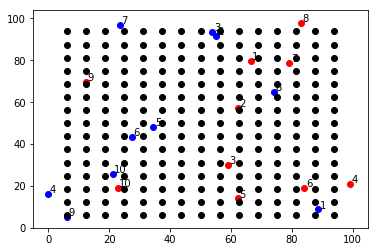

In [117]:
'''Visualize Points'''

def plot_points_1D(source, target, orig, number_points=True, dim_len=dim_len):
    '''
    Event plot of source, target and original points in 1D
    source - transformed source points
    original - original source points
    number_points - Label each point with its index in the array (useful for observing where the source points move)
    '''
    source_, target_ = np.copy(source).reshape(-1), np.copy(target).reshape(-1) # because eventplot modifies inplace
    plt.figure()
    plt.hlines(1,1,dim_len)
    
    # Scatter plots
    plt.eventplot(source_, orientation='horizontal', colors='b') # Source points in blue
    plt.eventplot(target_, orientation='horizontal', colors='r') # Target points in red
    if orig is not None:
        orig_  = np.copy(orig)
        plt.eventplot(orig_, orientation='horizontal', colors='y') # Original points in yellow
        
    # Label
    if number_points:
        for i in range(source.shape[0]):
            plt.annotate(i+1, (source[i], 0.8))
            plt.annotate(i+1, (target[i], 1.2))
            if orig is not None:
                plt.annotate(i+1, (orig[i], 0.5))
    plt.show()

def plot_points_2D(source, target, orig, number_points=True, dim_len=dim_len):
    '''Scatter plot of source, target and original points in 2D'''
    
    plt.scatter(source[:,0], source[:,1], c='b') # Source points in blue
    plt.scatter(target[:,0], target[:,1], c='r') # Target points in red
    if orig is not None:
        plt.scatter(orig[:,0], orig[:,1], c='y') # Original points in yellow
        
    # Label
    if number_points:
        offset = dim_len / 200
        for i in range(source.shape[0]):
            plt.annotate(i+1, source[i] + offset)
            plt.annotate(i+1, target[i] + offset)
            if orig is not None:
                plt.annotate(i+1, orig[i] + offset)
    plt.show()
    
def plot_points_2D_full(source, target, space, orig, number_points=True, dim_len=dim_len):
    '''Scatter plot of source, target, original points and entire source space in 2D'''
    
    plt.scatter(source[:,0], source[:,1], c='b') # Source points in blue
    plt.scatter(target[:,0], target[:,1], c='r') # Target points in red
    plt.scatter(space[:,0], space[:,1], c='black') # Space points are black
    if orig is not None:
        plt.scatter(orig[:,0], orig[:,1], c='y') # Original points in yellow
        
    # Label
    if number_points:
        for i in range(source.shape[0]):
            offset = dim_len / 200
            plt.annotate(i+1, source[i] + offset)
            plt.annotate(i+1, target[i] + offset)
            if orig is not None:
                plt.annotate(i+1, orig[i] + offset)
    plt.show()

def plot_points(source, target, source_space=source_space, orig=None, num_dims=num_dims):
    if num_dims == 1:
        plot_points_1D(source, target, orig)
    elif num_dims == 2:
        if source_space is None:
            plot_points_2D(source, target, orig)
        else:
            plot_points_2D_full(source, target, source_space, orig)
    else:
        raise Exception("Can't plot #dims = ", num_dims)
    
plot_points(source, target)

In [118]:
def check_gradients(param, fn, grads, epsilon=1e-4, threshold=1e-7):
    '''
    Approximately compute expected gradients of a function wrt each paramter and check it against 
    the computed gradients
    Report threshold breaches
    fn must expect param as its only argument
    '''
    params_shape = param.shape
    param = param.reshape(-1) # Flatenning parameters
    
    # Approx grads
    grads_approx = np.zeros_like(param)
    for i in range(param.size):
        orig = param[i]
        param[i] = orig - epsilon
        fn_l = fn(param.reshape(params_shape))
        param[i] = orig + epsilon
        fn_r = fn(param.reshape(params_shape))
        param[i] = orig
        grads_approx[i] = (fn_r - fn_l) / (2*epsilon)
    
    # Diff norm
    norm = np.linalg.norm(grads.reshape(params_shape) - grads_approx.reshape(params_shape))
    
    if norm > threshold:
        print('Violation: Norm:{}, Threshold:{}'.format(norm, threshold))
        print('param', param.reshape(params_shape))
        print('grad', grads.reshape(params_shape))
        print('grad approx', grads_approx.reshape(params_shape))
        print('grad diff', (grads.reshape(params_shape) - grads_approx.reshape(params_shape)))
        return False
    else:
        print('No Violation: ', norm)
        return True

In [119]:
'''
Cost functions for various modes
'''

def get_cost_1D_sort(source, target):
    '''
    If the constraint is only along a single dimension, one option is to map each source point to its closest target
    point. But since we want a one to one (bijective) mapping, we can instead sort the source and target points and map
    the corresponding elements in the sorted arrays. This cost function minimizes the pairwise distance b/w corresponding
    source and target points both sorted
    '''
    source = np.sort(source, axis=0)
    target = np.sort(target, axis=0)
    return (np.sum(np.square(source - target))) / (2 * source.size)

def get_cost_ND_sort(source, target):
    '''
    Extending the idea to N dimensions we can optimize all dimensions independently
    
    Problem: Once mapped, the transformed source space will resemble the target space along individual dimensions
    but there might not be an overall resemblence
    For Example, in the following example, there will be no change in source as individual dimensions are already optimal
        Source: [[10, 10], [20, 20], [30, 30]]
        Target: [[10, 30], [20, 20], [30, 10]]
    '''
    cost = 0
    for i in range(source.shape[1]):
        cost += get_cost_1D_sort(source[:,i], target[:,i])
    return cost

def get_cost_elasticity(source, source_orig, elasticity):
    '''
    Keeps source close to its original position 
    Motivation: Some points may have to move too far to reach their target. This may be avoided by penalizing points
    for moving too far from their origianl positions
    TODO: 
    '''
    return (elasticity * (np.sum(np.square(source - source_orig)))) / (2*source.size)

# def softmin(x):
#     exp = np.exp(-x)
#     mn = exp / np.sum(exp, axis=1, keepdims=True)
#     return mn

# def get_cost_1D2(source, target):
# #     print(source)
#     dist = np.zeros((target.shape[0], source.shape[0]))
#     for i in range(dist.shape[0]):
#         for j in range(dist.shape[1]):
#             dist[i][j] = abs(source[j] - target[i])
#     mn = softmin(dist)
#     cost = np.sum(mn * dist)
# #     print(cost)
#     return cost
    


# def get_cost_2D(source, target):
#     '''
#     The idea is to first find out which point in the 2D space should map to which point 
#     '''
#     pass

# def get_cost_2D(source, target):
#     '''
#     Here we explore the idea that as cannot trivially pre-determine the
#     '''
#     pass
    

def get_cost(source, target, source_orig=None, optimization=optimization, elasticity=0.5):
    if optimization == 'indep':
        cost = get_cost_ND_sort(source, target)
    else:
        raise Exception('Invalid Mode:', optimization)
        
    if elasticity is not None and source_orig is not None:
        cost += get_cost_elasticity(source, source_orig, elasticity)
    
    return cost
    
if True:
    print('Test Cost:', get_cost(source, target, source_orig=source*0.2))

Test Cost: 871.2662241815094


In [120]:
'''
Gradients of cost functions wrt source points
'''

def get_dsource_1D_sort(source, target):
    sidx = source.argsort() # Get the index list that sorts the array
    tidx = target.argsort()
    # Compute derivative wrt sorted source and the sort it back to its original order
    return ((source[sidx] - target[tidx]) / source.size)[sidx.argsort()]

def get_dsource_ND_sort(source, target):
    dsource = np.ones_like(source)
    for i in range(source.shape[1]):
        dsource[:,i] = get_dsource_1D_sort(source[:,i], target[:,i])
    return dsource

# def dSoftmin(x):
#     s = softmin(x)
#     return s * (1-s)

# def get_cost_1D2(source, target):
# #     print(source)
#     dist = np.zeros((target.shape[0], source.shape[0]))
#     for i in range(dist.shape[0]):
#         for j in range(dist.shape[1]):
#             dist[i][j] = abs(source[j] - target[i])
# #     return np.sum(dist)
#     mn = softmin(dist)
#     return np.sum(mn)
# #     cost = np.sum(mn * dist)
# #     print(cost)
# #     return cost

# def get_dSource_1D2(source, target):
# #     print(source, target)
#     dist = np.zeros((target.shape[0], source.shape[0]))
#     for i in range(dist.shape[0]):
#         for j in range(dist.shape[1]):
#             dist[i][j] = source[j] - target[i]
# #     print('dist', dist)
#     abs_dist = np.absolute(dist)
# #     print('abs_dist', abs_dist)
#     dDist = np.where(dist > 0, 1, -1)
# #     return np.sum(dDist, axis=0).reshape(-1, 1)
# #     print('dDist', dDist)
#     soft = softmin(abs_dist)
# #     print('soft', soft)
#     dsoft = dSoftmin(abs_dist)*dDist
#     return np.sum(dsoft, axis=0).reshape(-1, 1)
# #     return np.sum(dsoft, axis=0)
# #     print('dsoft', dsoft)
# #     dSource = (dsoft*abs_dist) + (soft*dDist)
# #     print(dSource)
# #     dSource = np.sum(dSource, axis=0).reshape(-1, 1)
# #     print(dSource)
# #     return dSource

# for _ in range(100):
# #     temp = np.random.rand(3,1)*100
# #     check_gradients(temp, softmin, dSoftmin(temp))
#     src, tgt = get_dataset_1D(100)
#     check_gradients(src, lambda s: get_cost_1D2(s, tgt), get_dSource_1D2(src, tgt))


def get_dsource_elasticity(source, source_orig, elasticity):
    return (elasticity * (source - source_orig)) / source.size

def get_dsource(source, target, source_orig=None, optimization=optimization, elasticity=0.5):
    if optimization == 'indep':
        dsource = get_dsource_ND_sort(source, target)
    else:
        raise Exception('Invalid Mode:', optimization)
        
    if elasticity is not None and source_orig is not None:
        dsource += get_dsource_elasticity(source, source_orig, elasticity)
    
    return dsource

if True:
    print('Test gradients:', get_dsource(source, target, source_orig=source*0.2))
    
if False:
    def _gc():
        for _ in range(100):
            src, tgt = get_dataset(num_dims, num_points, dim_len)
            orig, _ = get_dataset(num_dims, num_points, dim_len)
            e = np.random.rand()
            grads = get_dsource(src, tgt, source_orig=orig, optimization=optimization, elasticity=e)
            if not check_gradients(
                src, 
                lambda s: get_cost(s, tgt, source_orig=orig, optimization=optimization, elasticity=e),
                grads
            ):
                print('tgt', tgt)
                print('orig', orig)
    _gc()

Test gradients: [[ 0.72500617 -0.84462418]
 [-1.69120178  3.13648447]
 [-1.44649565  3.23923539]
 [-1.23430683  0.0396981 ]
 [-2.5132926   0.0516939 ]
 [-2.95045139  2.21652306]
 [-3.39089827  1.87608372]
 [ 0.49146061  0.80498723]
 [-1.55517993 -0.78938507]
 [-3.3695695   0.99018992]]


In [121]:
# def softmin(x):
#     exp = np.exp(-x)
#     mn = exp / np.sum(exp, axis=1, keepdims=True)
#     return np.sum(mn)

# def dSoftmin(x):
# #     dsoft = np.zeros_like(x)
# #     for i in range(x.shape[0]):
# #         a = x[0].reshape(-1,1)
# #         print(a)
# #         b = x[0].reshape(1,-1)
# #         print(b)
# #         j = np.dot(a,b)
# #         print(j)
# #         s = np.identity(a.size) * a
# #         print(s)
# #         print(j.shape, s.shape)
# #         dsoft[i] = np.sum(s - j, axis=0)
# #         print(dsoft[i])
# #     return dsoft
#     s = softmin(x)
#     return s*(1-s)
                
# for _ in range(100):
#     temp = np.random.rand(1,3)
#     check_gradients(temp, softmin, dSoftmin(temp))

In [126]:
def update_space(space, source, delta, dist_factor=0.1):
    '''
    Updates the space points (in-place) whenever the source points move
    To be executed at each step of gradient descent
    space - space points
    source - source points before movement
    delta - movement of source points
    dist_factor - points at a distance d move in proportion to "1 / (d ^ dist_factor)"
    
    Imagine that the space is an elastic surface like the surface of a balloon. Given that a point p is moved in
    some direction, all other points p' in the space will experience a force along the line l connecting them to p, the
    magnitude of which will be eqal to the force on p resolved along l. Moreover, the force experienced by p' is inversely
    poropotional to the distance b/w p and p'
    
    Note: this can perhaps be solved in one go using integration which will be complex to implement but way faster
    '''
    space = np.copy(space)
    for point in space:
        point_dx = point_dy = 0 # To store final displacements of each space point
        
        # Compute displacement corresponding to each source point
        for src, disp in zip(source, delta):
            ang1 = np.arctan2(disp[1], disp[0]) # Angle made by displacement vector of the source point
            pDistVec = src - point # Vector b/w space and source points
            ang2 = np.arctan2(pDistVec[1], pDistVec[0]) # Angle b/w space and source points
            pDist = np.sqrt(np.sum(np.square(pDistVec))) # Distance b/w space and source points
            
            # Displacement resolved along the line connecting source and space point
            pDisp = np.sqrt(np.sum(np.square(disp))) * np.cos(ang1 - ang2)
            
            # Displacement adjusted by disatance factor
            pDisp = pDisp  / (1 + np.power(pDist, dist_factor))
            
            # Displacement of source points along x and y directions
            # We do not want to add up the displacement cause by the source points but rather take the maximum
            dx = pDisp * np.cos(ang2)
            point_dx = (dx if abs(dx) > abs(point_dx) else point_dx) if point_dx * dx > 0 else point_dx + dx 
            dy = pDisp * np.sin(ang2)
            point_dy = (dy if abs(dy) > abs(point_dy) else point_dy) if point_dy * dy > 0 else point_dy + dy
            
        point[0] += point_dx
        point[1] += point_dy
    return space

# Debugging
if source_space is not None:
    temp_space = np.copy(source_space)
    update_space(temp_space, source, np.ones_like(source)*5)

In [127]:
def optimize(source, target, source_space=None, num_iters=10, learning_rate=0.1, elasticity=0.5):
    '''
    Optimizes the cost function using gradient descent
    The source points are gradually moved using their gradients wrt the cost function
    '''
    source_orig = source
    costs = []
    for i in range(num_iters):
        cost = get_cost(source, target, source_orig=source_orig, elasticity=elasticity)
        costs.append(cost)
        dSource = get_dsource(source, target, source_orig=source_orig, elasticity=elasticity)
        delta = -1 * learning_rate * dSource
        if source_space is not None:
            source_space = update_space(source_space, source, delta)
        source = source + delta
    return source, costs, source_space

# Perform mapping via optimization of cost function
source_new, costs, source_space_new  = optimize(source, target, source_space=source_space, num_iters=100, learning_rate=0.3, elasticity=0.2)

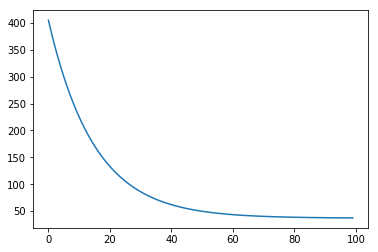

In [128]:
# Costs decreasing with iterations
def plot_costs(costs):
    plt.plot(costs)
plot_costs(costs)

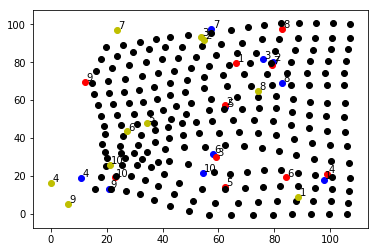

In [129]:
# The source points should now have approached their corresponding target points
plot_points(source_new, target, orig=source, source_space=source_space_new)